# Stock Market Big Data Analysis Using Spark


## Initiating Spark Session

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import sklearn
from sklearn.decomposition import PCA 

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, col, skewness, kurtosis, lead, when
from pyspark.sql.window import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, PCA, StandardScaler
from pyspark.sql.functions import to_date

In [2]:
spark = SparkSession.builder.appName('Stock_Market_Prediction').getOrCreate()

## Reading dataset from .CSV file

In [3]:
#df = spark.read.option('header', 'true').csv("../../SIEMENS_minute_data_with_indicators.csv", sep = ',' , inferSchema = True)
df = spark.read.option('header', 'true').csv("stock_dataset.csv", sep = ',' , inferSchema = True)

In [6]:
#df.show(5)

In [6]:
type(df)

pyspark.sql.dataframe.DataFrame

In [7]:
# df.columns
# df.dtypes
df.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- close: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- open: double (nullable = true)
 |-- volume: integer (nullable = true)
 |-- sma5: double (nullable = true)
 |-- sma10: double (nullable = true)
 |-- sma15: double (nullable = true)
 |-- sma20: double (nullable = true)
 |-- ema5: double (nullable = true)
 |-- ema10: double (nullable = true)
 |-- ema15: double (nullable = true)
 |-- ema20: double (nullable = true)
 |-- upperband: double (nullable = true)
 |-- middleband: double (nullable = true)
 |-- lowerband: double (nullable = true)
 |-- HT_TRENDLINE: double (nullable = true)
 |-- KAMA10: double (nullable = true)
 |-- KAMA20: double (nullable = true)
 |-- KAMA30: double (nullable = true)
 |-- SAR: double (nullable = true)
 |-- TRIMA5: double (nullable = true)
 |-- TRIMA10: double (nullable = true)
 |-- TRIMA20: double (nullable = true)
 |-- ADX5: double (nullable = true)
 |-- ADX10

In [11]:
df.columns
len(df.columns)

60

In [ ]:
correlated = ['close', 'high', 'low', 'open', 'sma5', 'sma10', 'sma15', 'sma20', 'ema5', 'ema10', 'ema15', 'ema20', 'upperband','middleband', 'lowerband', 'HT_TRENDLINE', 'KAMA10', 'KAMA20', 'KAMA30', 'TRIMA5', 'TRIMA10', 'TRIMA20']
len(correlated)

In [12]:
# making pandas df for visualizations
df = df.withColumn('date', to_date(df.date, 'yyyy-MM-dd'))
pandas_df = df.toPandas()


## Data Exploration

### Duplicates

In [6]:
if df.count() > df.dropDuplicates(df.columns).count():
    raise ValueError('Data has duplicates')
else: print("Data has no duplicates.")

Data has no duplicates.


### Missing Values

In [7]:
if df.count() > df.na.drop().count():
    raise ValueError('Data has null values')
else: print("Data has no missing values.")

Data has no missing values.


### Univariate Analysis

In [19]:
# df.describe().show()

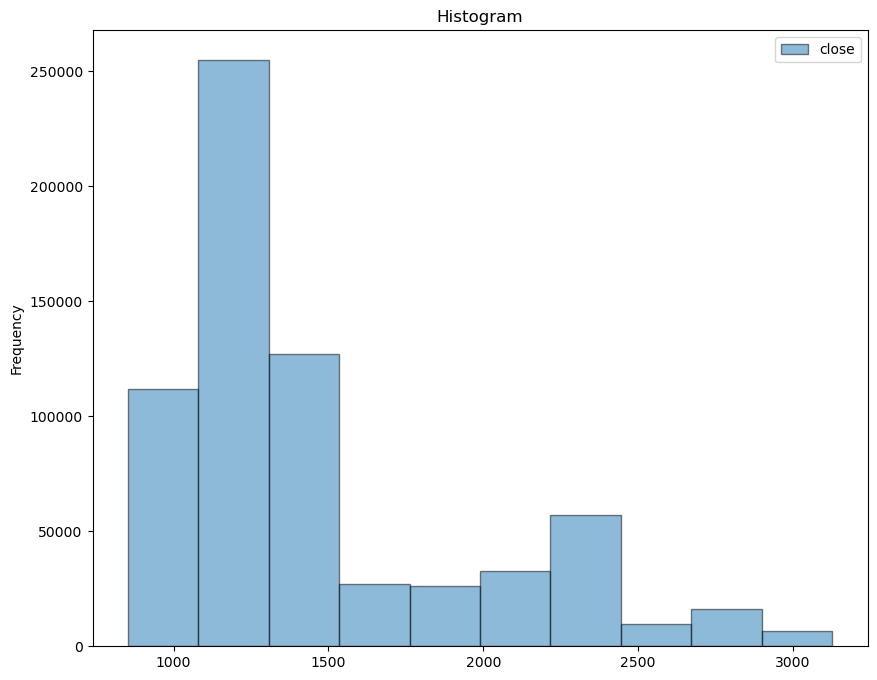

In [19]:
plt.figure(figsize=(10,8))

#for var in ['close','volume','SAR','ROC5']:
x = pandas_df['close']
plt.hist(x, alpha=0.5, histtype='bar', #color='gold',
         ec='black', label='close')#,weights=np.zeros_like(x) + 100. / x.size)

plt.ylabel('Frequency')
plt.title('Histogram')
plt.legend()
plt.show()

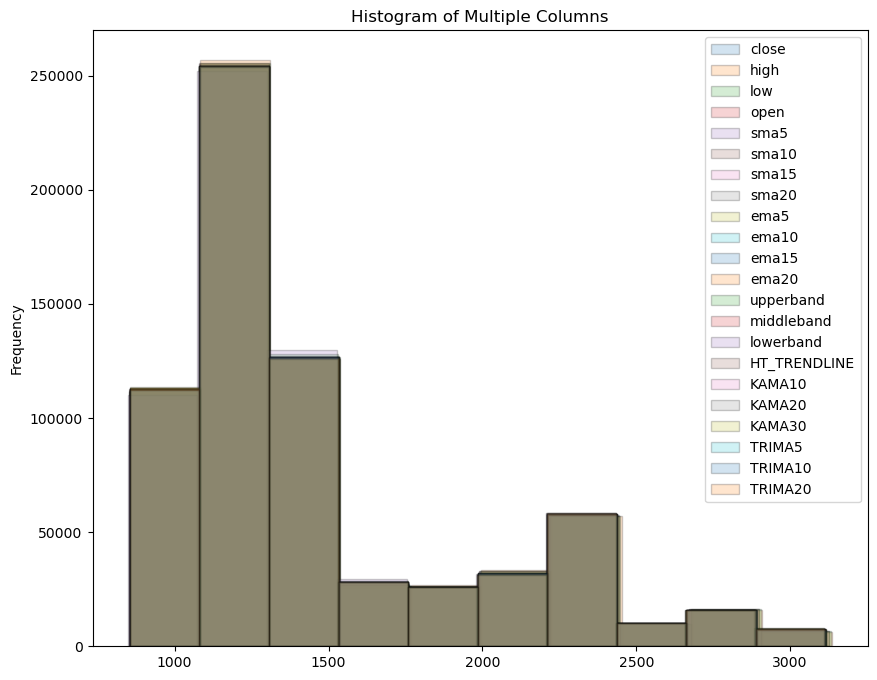

In [17]:
plt.figure(figsize=(10,8))

for var in pandas_df.drop(['volume', "SAR"], axis = 1).iloc[:,1:23]:
    x = pandas_df[var]
    plt.hist(x, alpha=0.2, histtype='bar', #color='gold',
             ec='black', label=var)#,weights=np.zeros_like(x) + 100. / x.size)

plt.ylabel('Frequency')
plt.title('Histogram of Multiple Columns')
plt.legend()
plt.show()

# fig.savefig(var+".pdf", bbox_inches='tight')

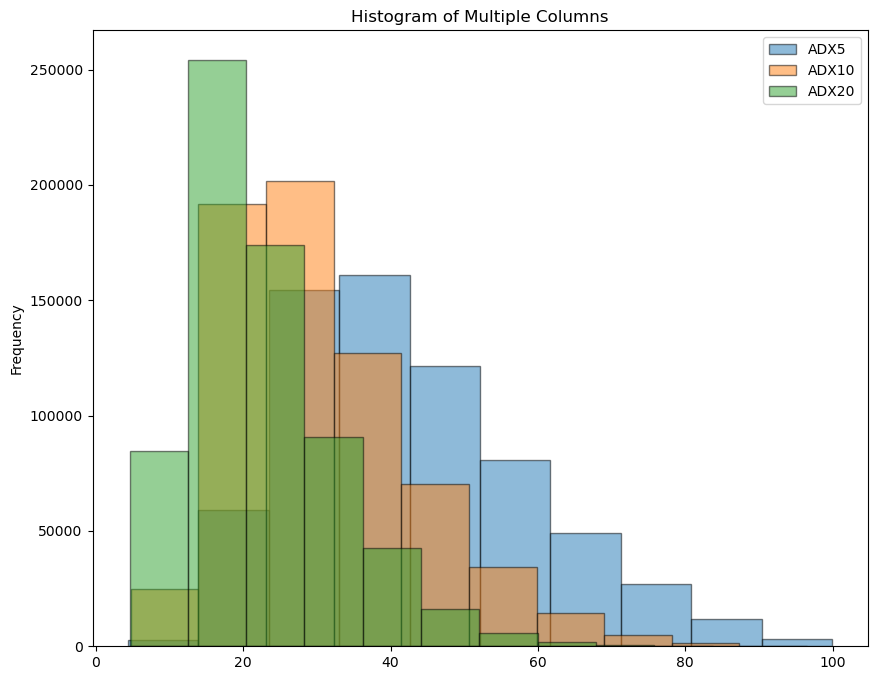

In [12]:
plt.figure(figsize=(10,8))

for var in pandas_df.iloc[:,25:28]:
    x = pandas_df[var]
    plt.hist(x, alpha=0.5, histtype='bar', #color='gold',
             ec='black', label=var)#,weights=np.zeros_like(x) + 100. / x.size)

plt.ylabel('Frequency')
plt.title('Histogram of Multiple Columns')
plt.legend()
plt.show()

# fig.savefig(var+".pdf", bbox_inches='tight')

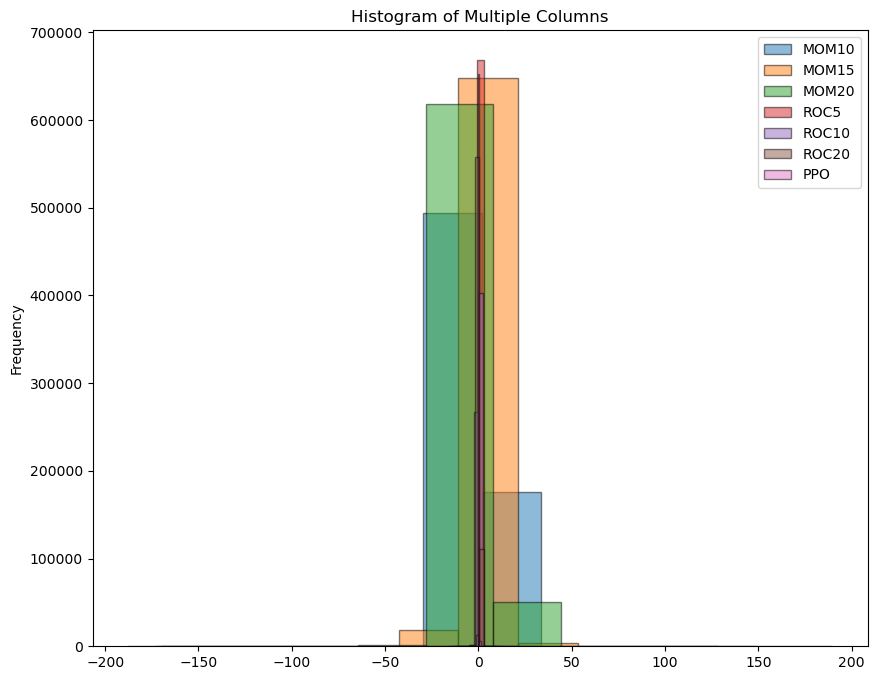

In [15]:
plt.figure(figsize=(10,8))

for var in pandas_df.iloc[:,38:45]:
    x = pandas_df[var]
    plt.hist(x, alpha=0.5, histtype='bar', #color='gold',
             ec='black', label=var)#,weights=np.zeros_like(x) + 100. / x.size)

plt.ylabel('Frequency')
plt.title('Histogram of Multiple Columns')
plt.legend()
plt.show()

# fig.savefig(var+".pdf", bbox_inches='tight')

### Multivariate Analysis

Text(0, 0.5, 'close')

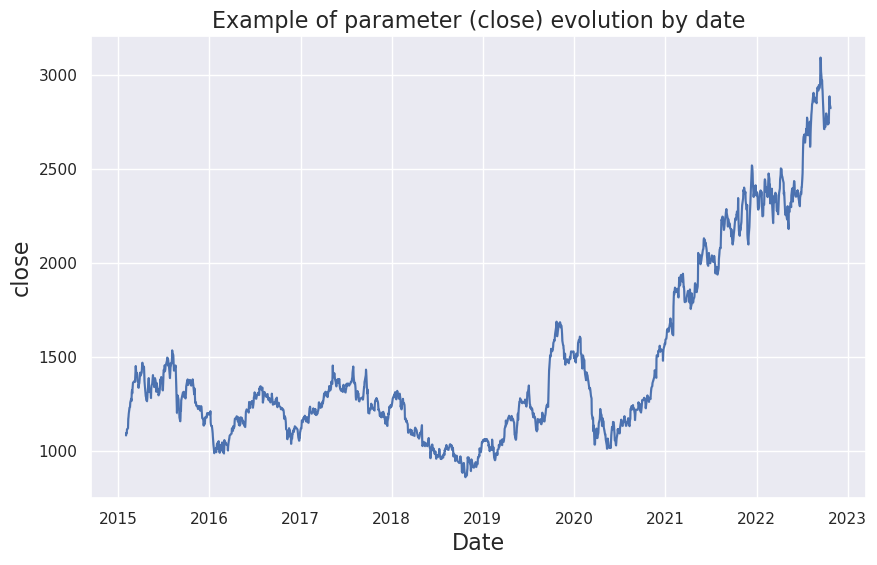

In [18]:
plt.rcParams['figure.figsize'] =(16,9)
plt.style.use('ggplot')
sns.set()
var = "close"

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title(f'Example of parameter ({var}) evolution by date', fontsize=16)
ax1.tick_params(axis='y')
ax1 = sns.lineplot(x='date', y=var, data = pandas_df)
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel(var, fontsize=16)

## Feature Normalization

### Pricipal Component Analysis (PCA)

In [6]:
# PCA (Pyspark - all data)

n_components = len(all_numeric)
pca_eval_all = PCA(
    k = n_components, 
    inputCol = 'scaled_all_features', 
    outputCol = 'pca_all_features'
).fit(df)

#importance/removal of features
temp = pca_eval_all.transform(df)
print('Explained Variance Ratio', pca_eval_all.explainedVariance.toArray())

Explained Variance Ratio [4.02379488e-01 2.54982928e-01 9.90438799e-02 4.12887625e-02
 2.60932477e-02 2.19950559e-02 2.00732211e-02 1.66964171e-02
 1.60318333e-02 1.51349527e-02 1.29626109e-02 1.02163641e-02
 9.56464236e-03 9.24413591e-03 7.10294381e-03 5.99755229e-03
 5.40393394e-03 4.71059154e-03 3.65449574e-03 3.22852420e-03
 3.03632631e-03 2.07938526e-03 1.75219039e-03 1.60829348e-03
 1.36345446e-03 1.23028029e-03 7.51621191e-04 7.28983697e-04
 6.05076391e-04 5.01445330e-04 3.20600543e-04 1.50044517e-04
 5.23009702e-05 1.19757900e-05 1.48730212e-06 3.74137725e-07
 3.15960124e-07 7.02739120e-08 6.18963519e-08 4.76703249e-08
 2.88301511e-08 2.33383368e-08 1.08554720e-08 7.35272188e-09
 4.85046222e-09 3.62642041e-09 2.36815903e-09 1.21819586e-09
 5.41768721e-10 9.02145585e-11 1.59406945e-11 1.14642082e-15
 2.90912659e-16 2.90801444e-16 1.18215200e-16 4.53160398e-17
 4.37485322e-17 4.37174211e-17 4.37174211e-17]


In [7]:
# PCA (Pyspark - all data) 
# choosing the first 12 components(component %): 1st: 0.40; 2nd: 0.25; 3rd: 0.10; 4th: 0.04; 5th: 0.026; 6th: 0.021; 7th: 0.02; 8th: 0.017;
# 9th: 0.016; 10th: 0.015; 11th: 0.013; 12th: 0.010)

pca_eval_all = PCA(
    k = 12, 
    inputCol = 'scaled_all_features', 
    outputCol = 'pca_all_features'
).fit(df)

df = pca_eval_all.transform(df)
print('Explained Variance Ratio', pca_eval_all.explainedVariance.toArray())

Explained Variance Ratio [0.40237949 0.25498293 0.09904388 0.04128876 0.02609325 0.02199506
 0.02007322 0.01669642 0.01603183 0.01513495 0.01296261 0.01021636]


In [8]:
# PCA (Pyspark - correlated)

pca_eval = PCA(
    k = 1, 
    inputCol = 'scaled_corr_features', 
    outputCol = 'pca_corr_features'
).fit(df)

# choosing the first component (k = 1) (component %: 1st: 0.99999)
df = pca_eval.transform(df)
print('Explained Variance Ratio', pca_eval.explainedVariance.toArray())

Explained Variance Ratio [0.99998649]


## Create file from dataframe

In [9]:
# Convert to rdd
rdd=df.rdd

In [10]:
# rdd to file
rdd.saveAsPickleFile("pca_pickle")

## Read file to dataframe

In [15]:
# read pkl file using current session spark context (RDD read)
rdd = spark.sparkContext.pickleFile("pca_pickle")

In [18]:
# create dataframe from RDD
df = rdd.toDF()

### Make df with Selected Features

In [24]:
# Create a window to look ahead by one row (one minute)
w = Window.orderBy('date')

# SHOULD WE ADAPT THIS?:
# Create the 'buy_or_sell' column
df_labeled = df.withColumn('buy_or_sell', when(lead('high', 1).over(w) > df['high'], 1).otherwise(0))

# WHY THESE FEATURES?:
# Define features and label
# all features that can be used (for example it might be better to not mix non_scaled with scaled)
features = ['all_features', 'corr_features', 'non_corr_features', 'scaled_all_features', 'scaled_corr_features', 'scaled_non_corr_features', 'pca_all_features', 'pca_corr_features']
label = 'buy_or_sell'

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=features, outputCol='features')

## Machile Learning

Plan:
- Select best features
- gradient boosting tree
- neural network
- Autoregressive models: SARS or Sarima, armax, garchx
- sve
- clustering

In [25]:
# Define the classifier
rf = RandomForestClassifier(labelCol=label, featuresCol='features')

# Build the pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Split data into training and test sets
train_data, test_data = df_labeled.randomSplit([0.7, 0.3])

# Fit the model
model = pipeline.fit(train_data)

# Make predictions on test data
predictions = model.transform(test_data)

## Evaluation of the Models

In [26]:
# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol=label)
accuracy = evaluator.evaluate(predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6402441467889414
